# Policy Gradient on cartpole
In this notebook, we run the policy gradient algorithm on the cartpole example. 
* [You can read about the cartpole problem here.](cartpole.ipynb)
* [You can read about policy gradient here.](pg_notebook.ipynb)
* [You can see the pure code for policy gradient on cartpole here.](./cartpole/pg_on_cartpole.py)

## Summary of the algorithm
We build a (deep) network to represent the probability density function $\pi_\theta$= `network(state).`


```
network = keras.Sequential([
            keras.layers.Dense(30, input_dim=n_s, activation='relu'),
            keras.layers.Dense(30, activation='relu'),
            keras.layers.Dense(n_a, activation='softmax')])
network.compile(loss='categorical_crossentropy')
```

Then, we iteratively improve the network. In each iteration of the algorithm, we do the following

* i. We rollout the environment to collect data for PG by following these steps:
    * i.a. We initialize empty histories for `states=[]`, `actions=[]`, `rewards=[]`
    * i.b. We observe the `state` $s$ and sample `action` $a$ from the poliy pdf $\pi_{\theta}(s)$
    
    `softmax_out = network(state)`
    
    `a = np.random.choice(n_a, p=softmax_out.numpy()[0])`
    
    * i.c. We derive the environment using $a$ and observe the `reward` $r$.
    * i.d. We add $s,\:a,\:r$ to the history batch `states`, `actions`, `rewards`.
    * i.e. We continue from i.b. until the episode ends.
* ii. We improve the policy by following these steps
    * ii.a. We calculate the reward to go and standardize it. 
    * ii.b. We optimize the policy.
    
    `
    target_actions = tf.keras.utils.to_categorical(np.array(actions), n_a)
    loss = self.network.train_on_batch(states, target_actions, sample_weight=rewards_to_go)
    `
    

## Running on google colab
If you want to run on google colab, go ahead and run the following cell. If you want to run on your computer, skip this cell and start from Importing libraries.

In [ ]:
!git clone https://github.com/FarnazAdib/Crash_course_on_RL.git
%cd Crash_course_on_RL
!pip install .

## Importing libraries

We start coding by importing the required libraries. If you get an error, you have possibly forgotten to change the kernel. See [Prepare a virtual environment](Preparation.ipynb).

In [1]:
import numpy as np
import tensorflow as tf
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
from tensorflow import keras
import datetime as dt
import warnings
warnings.filterwarnings('ignore')
from cartpole.dynamics import CartPole
from cartpole.pltlib import PLTLIB

## Saving directories
Next, we set up some paths to write data and possibly capture some videos for future investigation.

In [2]:
STORE_PATH = '/tmp/cartpole_exp1/PG'
data_path = STORE_PATH + f"/data_{dt.datetime.now().strftime('%d%m%Y%H%M')}"
agent_path = STORE_PATH + f"/agent_{dt.datetime.now().strftime('%d%m%Y%H%M')}"
train_writer = tf.summary.create_file_writer(data_path)

## Making the environment
We select the random seed and make the cartpole environment.


In [3]:
Rand_Seed = 1
env_par = {
    'Rand_Seed': Rand_Seed,
    'STORE_PATH': STORE_PATH,
    'monitor': False,
    'threshold': 195.0
}
Rand_Seed = 1
CP = CartPole(env_par)

## Making the policy gradient agent
We define the policy gradient class. This class builds a network representing the pdf $\pi_{\theta}$ of the parametric policy. The parameter vector $\theta$ is the weights and biases in the network. The network has a structure which you can see in PG class. `hidden_size` denotes the number of nodes in the layers of the network. `GAMMA`is the discount factor $0\leq \gamma \leq 1$ quantifies how much we care about the immediate rewards and future rewards. We update the parameter vector $\theta$ by an ADAM optimizer which is a gradient algorithm. `learning_rate_adam`is the learning rate in ADAM optimizer is usually in $[0.0001,\:0.1]$. `adam_eps` is another hyperparameter to tune in ADAM algorithm. 




In [4]:
class PG:
    def __init__(self, hparams):
        self.hparams = hparams
        np.random.seed(hparams['Rand_Seed'])
        tf.random.set_seed(hparams['Rand_Seed'])

        # The policy network
        self.network = keras.Sequential([
            keras.layers.Dense(self.hparams['hidden_size'], input_dim=self.hparams['num_state'], activation='relu',
                               kernel_initializer=keras.initializers.he_normal(), dtype='float64'),
            keras.layers.Dense(self.hparams['hidden_size'], activation='relu',
                               kernel_initializer=keras.initializers.he_normal(), dtype='float64'),
            keras.layers.Dense(self.hparams['num_actions'], activation='softmax', dtype='float64')
        ])
        self.network.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(
            epsilon=self.hparams['adam_eps'], learning_rate=self.hparams['learning_rate_adam']))

    def get_action(self, state, env):
        
        # Building the pdf for the given state
        softmax_out = self.network(state.reshape((1, -1)))
        
        # Sampling an action according to the pdf
        selected_action = np.random.choice(self.hparams['num_actions'], p=softmax_out.numpy()[0])
        return selected_action

    def update_network(self, states, actions, rewards):
        reward_sum = 0
        rewards_to_go = []
        for reward in rewards[::-1]:  # reverse buffer r
            reward_sum = reward + self.hparams['GAMMA'] * reward_sum
            rewards_to_go.append(reward_sum)
        rewards_to_go.reverse()
        rewards_to_go = np.array(rewards_to_go)
        # standardise the rewards
        rewards_to_go -= np.mean(rewards_to_go)
        rewards_to_go /= np.std(rewards_to_go)
        states = np.vstack(states)
        target_actions = tf.keras.utils.to_categorical(np.array(actions), self.hparams['num_actions'])
        loss = self.network.train_on_batch(states, target_actions, sample_weight=rewards_to_go)
        return loss


Now that we have defined the PG class, it is enough to build an object and to iterate. You can change the following hyper parameters if you like. For example, you can set `GAMMA`: 0.9 to see if you can solve the problem faster.

* `hidden_size`: Number of nodes in the layers of the network.
* `GAMMA`: The discount factor $0\leq \gamma \leq 1$ quantifies how much we care about the immediate rewards and future rewards. We have two extreme cases 1. $\gamma \rightarrow 0$: We only care about the current reward not what we'll receive in future. 2. $\gamma \rightarrow 1$: We care about rewards at all times equally. We usually select $\gamma$ near to $1$.
* `num_episodes`: The maximum number of iterations to run the PG algorithm. You can increase it if the problem is not solved within the specified number of iterations
* `learning_rate_adam`: We have chosen ADAM optimizer for the gradient optimization. The learning rate is usually in $[0.0001,\:0.1]$ and it is usally selected by try and error. A good point to start is the defalut value in the ADAM optimizer which is 0.01. 
* `adam_eps`: This is another hyperparameter to tune in ADAM algorithm. Leave it as it is. You can read about it [here](https://arxiv.org/abs/1412.6980). The epsilon in adam optimization.

In [5]:
agent_par = {
    'num_state': CP.env.observation_space.shape[0],
    'num_actions': CP.env.action_space.n,
    'Rand_Seed': Rand_Seed,
    'hidden_size': 30,
    'GAMMA': 1.0,
    'num_episodes': 2000,
    'learning_rate_adam': 0.001,
    'adam_eps': 1e-7,
}
policy = PG(agent_par)

## Start learning
Now, we start the learning loop. The learning loop iterates for a maximum of number `num_episodes`. In each iteration
* The agent derives the environment for one episode to collect data for PG.
* We update the agent by policy gradient algorithm using the recorded data.
* We check if the problem is solved.
* We write the data.
At the end of the learning loop, we close the environment.

In [6]:
tot_rews = []
mean_100ep = 0
for episode in range(agent_par['num_episodes']):

    # Do one rollout
    states, actions, rewards, _, _ = CP.one_rollout(policy)

    # Update the network
    loss = policy.update_network(states, actions, rewards)

    # Check if the problem is solved
    if episode > 100:
        mean_100ep = np.mean(tot_rews[-101:-1])

    tot_reward = sum(rewards)
    tot_rews.append(tot_reward)
    print(f"Episode: {episode}, Reward: {tot_reward}, Mean of 100 cons episodes: {mean_100ep}")
    if mean_100ep > env_par['threshold']:
        print(f"Problem is solved.")
        policy.network.save(agent_path)
        break

    # Save data
    with train_writer.as_default():
        tf.summary.scalar('reward', tot_reward, step=episode)

# Close the environment
CP.env.close()


Episode: 0, Reward: 11.0, Mean of 100 cons episodes: 0
Episode: 1, Reward: 28.0, Mean of 100 cons episodes: 0
Episode: 2, Reward: 26.0, Mean of 100 cons episodes: 0
Episode: 3, Reward: 19.0, Mean of 100 cons episodes: 0
Episode: 4, Reward: 20.0, Mean of 100 cons episodes: 0
Episode: 5, Reward: 14.0, Mean of 100 cons episodes: 0
Episode: 6, Reward: 12.0, Mean of 100 cons episodes: 0
Episode: 7, Reward: 12.0, Mean of 100 cons episodes: 0
Episode: 8, Reward: 10.0, Mean of 100 cons episodes: 0
Episode: 9, Reward: 37.0, Mean of 100 cons episodes: 0
Episode: 10, Reward: 14.0, Mean of 100 cons episodes: 0
Episode: 11, Reward: 42.0, Mean of 100 cons episodes: 0
Episode: 12, Reward: 15.0, Mean of 100 cons episodes: 0
Episode: 13, Reward: 10.0, Mean of 100 cons episodes: 0
Episode: 14, Reward: 9.0, Mean of 100 cons episodes: 0
Episode: 15, Reward: 11.0, Mean of 100 cons episodes: 0
Episode: 16, Reward: 28.0, Mean of 100 cons episodes: 0
Episode: 17, Reward: 14.0, Mean of 100 cons episodes: 0
Epi

Episode: 146, Reward: 40.0, Mean of 100 cons episodes: 26.85
Episode: 147, Reward: 28.0, Mean of 100 cons episodes: 26.77
Episode: 148, Reward: 59.0, Mean of 100 cons episodes: 27.0
Episode: 149, Reward: 25.0, Mean of 100 cons episodes: 27.04
Episode: 150, Reward: 33.0, Mean of 100 cons episodes: 27.46
Episode: 151, Reward: 33.0, Mean of 100 cons episodes: 27.61
Episode: 152, Reward: 50.0, Mean of 100 cons episodes: 27.59
Episode: 153, Reward: 24.0, Mean of 100 cons episodes: 27.66
Episode: 154, Reward: 25.0, Mean of 100 cons episodes: 27.69
Episode: 155, Reward: 15.0, Mean of 100 cons episodes: 27.66
Episode: 156, Reward: 57.0, Mean of 100 cons episodes: 27.52
Episode: 157, Reward: 70.0, Mean of 100 cons episodes: 27.5
Episode: 158, Reward: 86.0, Mean of 100 cons episodes: 27.82
Episode: 159, Reward: 16.0, Mean of 100 cons episodes: 28.34
Episode: 160, Reward: 47.0, Mean of 100 cons episodes: 29.03
Episode: 161, Reward: 30.0, Mean of 100 cons episodes: 29.06
Episode: 162, Reward: 14.0

Episode: 281, Reward: 94.0, Mean of 100 cons episodes: 52.17
Episode: 282, Reward: 99.0, Mean of 100 cons episodes: 52.39
Episode: 283, Reward: 103.0, Mean of 100 cons episodes: 52.63
Episode: 284, Reward: 125.0, Mean of 100 cons episodes: 53.33
Episode: 285, Reward: 47.0, Mean of 100 cons episodes: 53.83
Episode: 286, Reward: 65.0, Mean of 100 cons episodes: 54.19
Episode: 287, Reward: 32.0, Mean of 100 cons episodes: 54.32
Episode: 288, Reward: 128.0, Mean of 100 cons episodes: 54.65
Episode: 289, Reward: 61.0, Mean of 100 cons episodes: 54.74
Episode: 290, Reward: 37.0, Mean of 100 cons episodes: 55.27
Episode: 291, Reward: 38.0, Mean of 100 cons episodes: 55.67
Episode: 292, Reward: 39.0, Mean of 100 cons episodes: 55.27
Episode: 293, Reward: 96.0, Mean of 100 cons episodes: 55.5
Episode: 294, Reward: 64.0, Mean of 100 cons episodes: 55.07
Episode: 295, Reward: 33.0, Mean of 100 cons episodes: 55.65
Episode: 296, Reward: 67.0, Mean of 100 cons episodes: 55.86
Episode: 297, Reward: 

Episode: 415, Reward: 175.0, Mean of 100 cons episodes: 107.79
Episode: 416, Reward: 85.0, Mean of 100 cons episodes: 106.44
Episode: 417, Reward: 110.0, Mean of 100 cons episodes: 107.05
Episode: 418, Reward: 101.0, Mean of 100 cons episodes: 107.16
Episode: 419, Reward: 117.0, Mean of 100 cons episodes: 107.82
Episode: 420, Reward: 86.0, Mean of 100 cons episodes: 108.23
Episode: 421, Reward: 158.0, Mean of 100 cons episodes: 108.97
Episode: 422, Reward: 124.0, Mean of 100 cons episodes: 108.07
Episode: 423, Reward: 115.0, Mean of 100 cons episodes: 108.56
Episode: 424, Reward: 66.0, Mean of 100 cons episodes: 109.42
Episode: 425, Reward: 119.0, Mean of 100 cons episodes: 109.14
Episode: 426, Reward: 122.0, Mean of 100 cons episodes: 108.71
Episode: 427, Reward: 200.0, Mean of 100 cons episodes: 108.47
Episode: 428, Reward: 106.0, Mean of 100 cons episodes: 108.85
Episode: 429, Reward: 95.0, Mean of 100 cons episodes: 109.53
Episode: 430, Reward: 168.0, Mean of 100 cons episodes: 109

Episode: 546, Reward: 161.0, Mean of 100 cons episodes: 162.61
Episode: 547, Reward: 163.0, Mean of 100 cons episodes: 161.65
Episode: 548, Reward: 200.0, Mean of 100 cons episodes: 161.85
Episode: 549, Reward: 200.0, Mean of 100 cons episodes: 161.85
Episode: 550, Reward: 165.0, Mean of 100 cons episodes: 162.45
Episode: 551, Reward: 134.0, Mean of 100 cons episodes: 162.99
Episode: 552, Reward: 200.0, Mean of 100 cons episodes: 162.64
Episode: 553, Reward: 96.0, Mean of 100 cons episodes: 162.82
Episode: 554, Reward: 200.0, Mean of 100 cons episodes: 164.28
Episode: 555, Reward: 200.0, Mean of 100 cons episodes: 163.29
Episode: 556, Reward: 200.0, Mean of 100 cons episodes: 163.66
Episode: 557, Reward: 195.0, Mean of 100 cons episodes: 164.34
Episode: 558, Reward: 200.0, Mean of 100 cons episodes: 165.06
Episode: 559, Reward: 161.0, Mean of 100 cons episodes: 165.77
Episode: 560, Reward: 200.0, Mean of 100 cons episodes: 165.77
Episode: 561, Reward: 142.0, Mean of 100 cons episodes: 

Episode: 677, Reward: 200.0, Mean of 100 cons episodes: 180.71
Episode: 678, Reward: 200.0, Mean of 100 cons episodes: 180.71
Episode: 679, Reward: 188.0, Mean of 100 cons episodes: 180.71
Episode: 680, Reward: 200.0, Mean of 100 cons episodes: 181.53
Episode: 681, Reward: 200.0, Mean of 100 cons episodes: 181.41
Episode: 682, Reward: 116.0, Mean of 100 cons episodes: 182.3
Episode: 683, Reward: 200.0, Mean of 100 cons episodes: 182.3
Episode: 684, Reward: 197.0, Mean of 100 cons episodes: 182.33
Episode: 685, Reward: 200.0, Mean of 100 cons episodes: 182.59
Episode: 686, Reward: 200.0, Mean of 100 cons episodes: 183.25
Episode: 687, Reward: 200.0, Mean of 100 cons episodes: 183.66
Episode: 688, Reward: 200.0, Mean of 100 cons episodes: 183.66
Episode: 689, Reward: 200.0, Mean of 100 cons episodes: 183.66
Episode: 690, Reward: 200.0, Mean of 100 cons episodes: 183.88
Episode: 691, Reward: 122.0, Mean of 100 cons episodes: 184.57
Episode: 692, Reward: 200.0, Mean of 100 cons episodes: 1

Episode: 808, Reward: 200.0, Mean of 100 cons episodes: 192.88
Episode: 809, Reward: 192.0, Mean of 100 cons episodes: 192.88
Episode: 810, Reward: 200.0, Mean of 100 cons episodes: 192.88
Episode: 811, Reward: 200.0, Mean of 100 cons episodes: 192.8
Episode: 812, Reward: 200.0, Mean of 100 cons episodes: 192.8
Episode: 813, Reward: 191.0, Mean of 100 cons episodes: 192.8
Episode: 814, Reward: 200.0, Mean of 100 cons episodes: 192.8
Episode: 815, Reward: 200.0, Mean of 100 cons episodes: 193.94
Episode: 816, Reward: 200.0, Mean of 100 cons episodes: 194.11
Episode: 817, Reward: 200.0, Mean of 100 cons episodes: 194.11
Episode: 818, Reward: 200.0, Mean of 100 cons episodes: 194.11
Episode: 819, Reward: 200.0, Mean of 100 cons episodes: 194.49
Episode: 820, Reward: 200.0, Mean of 100 cons episodes: 194.49
Episode: 821, Reward: 200.0, Mean of 100 cons episodes: 194.49
Episode: 822, Reward: 200.0, Mean of 100 cons episodes: 194.52
Episode: 823, Reward: 200.0, Mean of 100 cons episodes: 194

## Results
It will get around 1-2 minutes to run the above cell. You will probably get some WARNING\ERROR. Some of these are related to incompatibility between some libraries. Don't panic. The problem will be solved after possibly after 800-1200 episodes.You can see a summary of results by running the cell below. you can also see the evaluation of the rewards vs. iteration as the iteration goes on



Problem is solved after 831 Episode with the mean reward 195.96 over the last 100 episodes


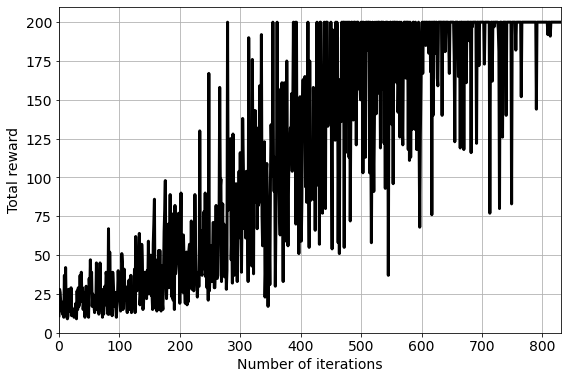

In [7]:
# Print the results if the problem is solved
if mean_100ep > env_par['threshold']:
    # Print the summary of the solution
    print(f"\n\nProblem is solved after {episode} Episode with the mean reward {mean_100ep} over the last 100 episodes")

    # Plot the result
    MyPlot = PLTLIB()
    MyPlot.reward_it(tot_rews)